<a href="https://colab.research.google.com/github/AV-BOLT/Used_car_price_prediction/blob/master/car_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Описание проекта #


Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля.

Постройте модель, которая умеет её определять. В вашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.

**Критерии, которые важны заказчику:**
- качество предсказания;
- время обучения модели;
- время предсказания модели.

Инструкция по выполнению проекта

Основные шаги:
Загрузите данные, путь к файлу: /datasets/autos.csv.
Изучите данные. Заполните пропущенные значения и обработайте аномалии в столбцах. Если среди признаков имеются неинформативные, удалите их.
Подготовьте выборки для обучения моделей.
Обучите разные модели, одна из которых — LightGBM, как минимум одна — не бустинг.

Для каждой модели попробуйте разные гиперпараметры.
Проанализируйте время обучения, время предсказания и качество моделей.

Опираясь на критерии заказчика, выберете лучшую модель, проверьте её качество на тестовой выборке.


Описание данных
Данные находятся в файле autos.csv.

Признаки
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя
- Целевой признак Price — цена (евро)



Критерии, которые важны заказчику:
- качество предсказания;
- время обучения модели;
- время предсказания модели.

**Требования:**

Обучите разные модели, одна из которых
- LightGBM,
- как минимум одна — не бустинг.
- Для каждой модели попробуйте разные гиперпараметры.
- Проанализируйте **время обучения**, **время предсказания** и к**ачество моделей**.
-Опираясь на критерии заказчика, выберете лучшую модель, проверьте её качество на тестовой выборке.

**Примечания:**

- Для оценки качества моделей применяйте метрику RMSE.
Значение метрики RMSE должно быть меньше 2500.
- Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.

# Загрузка данных и библиотек

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
import seaborn as sns
#import optuna

In [ ]:
import time

In [ ]:
!pip install catboost
import catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.9 MB/s eta 0:00:00


In [ ]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, Pool, cv
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer

In [ ]:
!pip install lightgbm
import lightgbm as lgb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [157]:
data = pd.read_csv('/content/drive/MyDrive/Projects_YP/Used_car_price_prediction/autos.csv')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [158]:
data.shape

(354369, 16)

Данные загружены, имеется 354 369 объектов и 16 признаков.


# Предобработка и анализ

In [159]:
# посмотрим на дынные
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [160]:
data.dtypes.to_frame()

,0
DateCrawled,object
Price,int64
VehicleType,object
RegistrationYear,int64
Gearbox,object
Power,int64
Model,object
Kilometer,int64
RegistrationMonth,int64
FuelType,object


- В данных имеются пропуски
- Имеются признаки с типом данных который не соответствует значениям в признаке
- Названия необходимо привести к единообразной форме (строчный регистр и _ для разделения)
- Данные представлены категориальными, числовыми признаками, datetime.


Этапы предобработки данных:

**приведение типов данных** к требуемому формату datetime (без времени):
- DateCrawled
- DateCreated
- LastSeen

**приведение названия признаков**  к единообразному формату

**пропуски**:
- Анализ причин возникновения пропусков
- Рассмотрение возможных способов обработки таких признаков(заглушка, использование inputer, оставить как есть если позволяет модель, заполнение синтетическими данными, заполнение на основании остальных признаков и т.д.)

примерный алгоритм обработки **категориальные признаки**,  значит необходимо обрабатывать их - приведение к единому написанию (регистр, пробелы/символы/цифры и тд.)
- проверка на дупликаты (явные и неявные)

**Числовые признаки** проверим
- на аномалии и редкие значения
-



## Приведение значений к требуемому формату

In [161]:
# Посмотрим, если они в одном формате представлены
#то их одновременно приведем к формату datetime
data[['DateCrawled', 'DateCreated', 'LastSeen']].head()

,DateCrawled,DateCreated,LastSeen
0,2016-03-24 11:52:17,2016-03-24 00:00:00,2016-04-07 03:16:57
1,2016-03-24 10:58:45,2016-03-24 00:00:00,2016-04-07 01:46:50
2,2016-03-14 12:52:21,2016-03-14 00:00:00,2016-04-05 12:47:46
3,2016-03-17 16:54:04,2016-03-17 00:00:00,2016-03-17 17:40:17
4,2016-03-31 17:25:20,2016-03-31 00:00:00,2016-04-06 10:17:21


In [162]:
date_columns = ['DateCrawled', 'DateCreated', 'LastSeen']

In [163]:
data[date_columns] = data[date_columns]\
            .applymap(lambda x: pd.to_datetime(x).date())

data[date_columns].head()

,DateCrawled,DateCreated,LastSeen
0,2016-03-24,2016-03-24,2016-04-07
1,2016-03-24,2016-03-24,2016-04-07
2,2016-03-14,2016-03-14,2016-04-05
3,2016-03-17,2016-03-17,2016-03-17
4,2016-03-31,2016-03-31,2016-04-06


Проверим, не одинаковые ли значения содержат признаки 'DateCrawled' и 'DateCreated', если разница будет в районе одного месяца то можно уверенно удалить один из признаков.

In [164]:
(data['DateCrawled'] == data['DateCreated']).all()


False

Значения в этих признаках не совпадают, значит они не дублирующие друг друга.

Оценим разницу в этих признаках

In [165]:
date_difference = data['DateCrawled'] - data['DateCreated']

In [166]:
date_difference.describe().to_frame()

,0
count,354369
mean,0 days 02:04:50.686826443
std,2 days 03:14:27.900291057
min,0 days 00:00:00
25%,0 days 00:00:00
50%,0 days 00:00:00
75%,0 days 00:00:00
max,737 days 00:00:00


Видим, что большая часть пользователей заполняют анкеты в день скачивания,

In [167]:
date_difference.value_counts(ascending = False).head(10).to_frame().transpose()

,0 days,1 days,2 days,3 days,4 days,6 days,5 days,7 days,8 days,15 days
0,342585,10273,543,85,80,77,72,65,45,41


In [168]:
date_difference.value_counts(ascending = True).head(10).to_frame().transpose()

,66 days,81 days,124 days,117 days,78 days,131 days,94 days,239 days,113 days,100 days
0,1,1,1,1,1,1,1,1,1,1


  Несмотря на то, что в этих данных имеются различия, мы можем заменить признак date_crawled на признак date_difference.
  Это сделать целесобразно потому что этот признак мы сохраним в числовом формате, что удобнее для кодирования и обработки.

In [169]:
data['date_difference'] = date_difference.dt.days
data['date_difference'].head()

0    0
1    0
2    0
3    0
4    0
Name: date_difference, dtype: int64

In [170]:
data['date_difference'].dtype

dtype('int64')

- Из значений в признаках, содержащих дату со временем извлечена дата, что позволит работать нам с только с датой
- Создан новый признак date_difference, который содержит количество дней от дня скачивания до дня создания анкеты.

## Приведение названий признаков к змеиному формату

In [171]:
data.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen',
       'date_difference'],
      dtype='object')

Необходимо:
- привести к строчному регистру
- добавить _ между словами

In [172]:
data.columns = ['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gear_box',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'repaired', 'date_created', 'pictures_amount', 'postal_code',
       'last_seen','date_difference']

In [173]:
data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year',
       'gear_box', 'power', 'model', 'kilometer', 'registration_month',
       'fuel_type', 'brand', 'repaired', 'date_created', 'pictures_amount',
       'postal_code', 'last_seen', 'date_difference'],
      dtype='object')

Названия исправлены.

## Анализ пропущенных значений

Заполнять все пропуски я буду заглушками, которые отличимы от реальных данных.

Синтетические данные я подбирать не буду.

Для каждого признака с пропущенными значениями я построю график чтобы оценить какие значения содержатся и какой масштаб (для числовых признаков).

- Числовые признаки числом, отличимым по масштабу от реальных данных -1
- Категориальные признаки заглушкой **no_info**

In [174]:
def pass_value_barh(df):
    try:(
        (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh',
                  figsize = (19,6),
                  rot = -0,
                  legend = False,
                  fontsize = 16,
                  xticks=[i/10 for i in range(0, 1000, 50)],
                  color='skyblue')
            .set_title('Количество пропущенных значений' + "\n", fontsize = 22, color = 'Black')
        );
    except:
        print('пропусков не осталось')

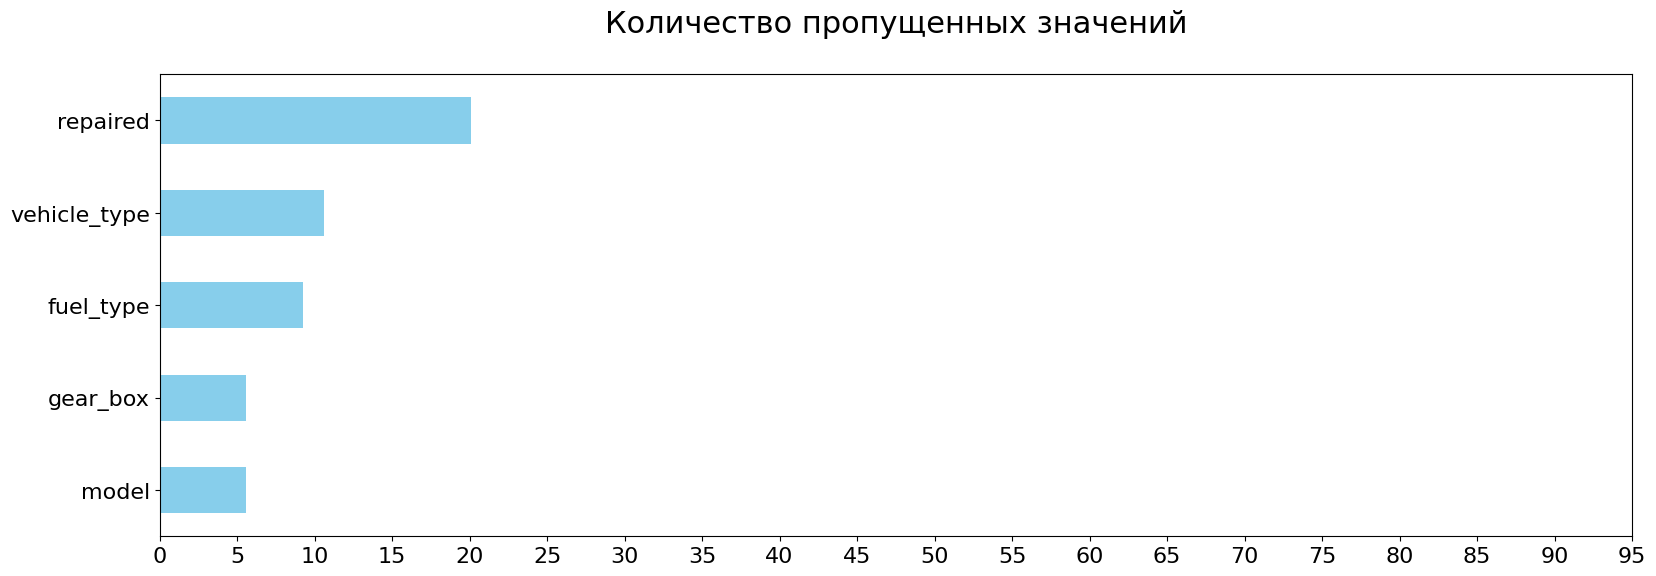

In [175]:
pass_value_barh(data)

### repaired

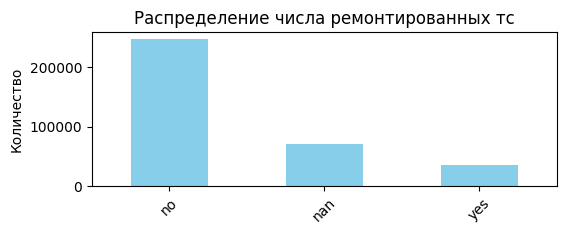

In [176]:
data['repaired'].value_counts(dropna=False).plot(kind='bar',
                                                 color='skyblue',
                                                 figsize = (6,2))
plt.title('Распределение числа ремонтированных тс')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.show()

### vehicle_type

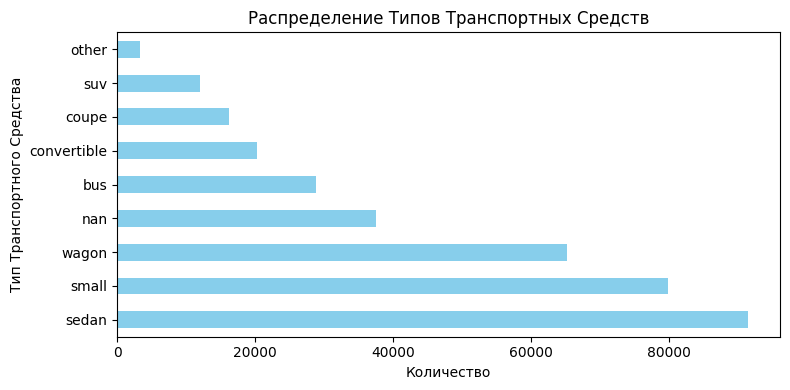

In [177]:
data['vehicle_type'].value_counts(dropna=False).plot(kind='barh',
                                                     color='skyblue',
                                                     figsize = (8,4))
plt.title('Распределение Типов Транспортных Средств')
plt.ylabel('Тип Транспортного Средства')
plt.xlabel('Количество')
plt.tight_layout()
plt.show()

### fuel_type

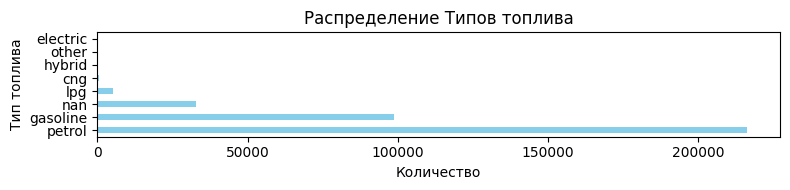

In [178]:
data['fuel_type'].value_counts(dropna=False).plot(kind='barh',
                                                  color='skyblue',
                                                  figsize = (8,2))
plt.title('Распределение Типов топлива')
plt.ylabel('Тип топлива')
plt.xlabel('Количество')
plt.tight_layout()
plt.show()

### gear_box

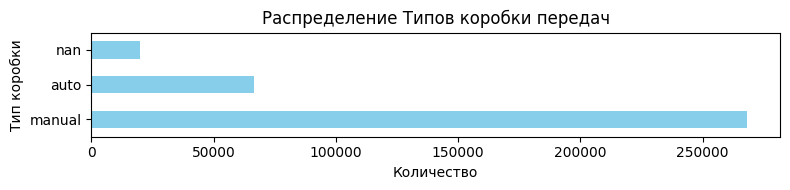

In [179]:
data['gear_box'].value_counts(dropna=False).plot(kind='barh',
                                                  color='skyblue',
                                                  figsize = (8,2))
plt.title('Распределение Типов коробки передач')
plt.ylabel('Тип коробки')
plt.xlabel('Количество')
plt.tight_layout()
plt.show()

### model

следующий признак один из важнейших, но график строить нецелесообразно из-за того, что в данном признаке содержится слишком много уникальных названий моделей автомобилей.

Значения категориальные и следовательно заполняем заглушкой no_info

### Заполняем пропуски

In [180]:
data = data.fillna('no_info')

пропусков не осталось


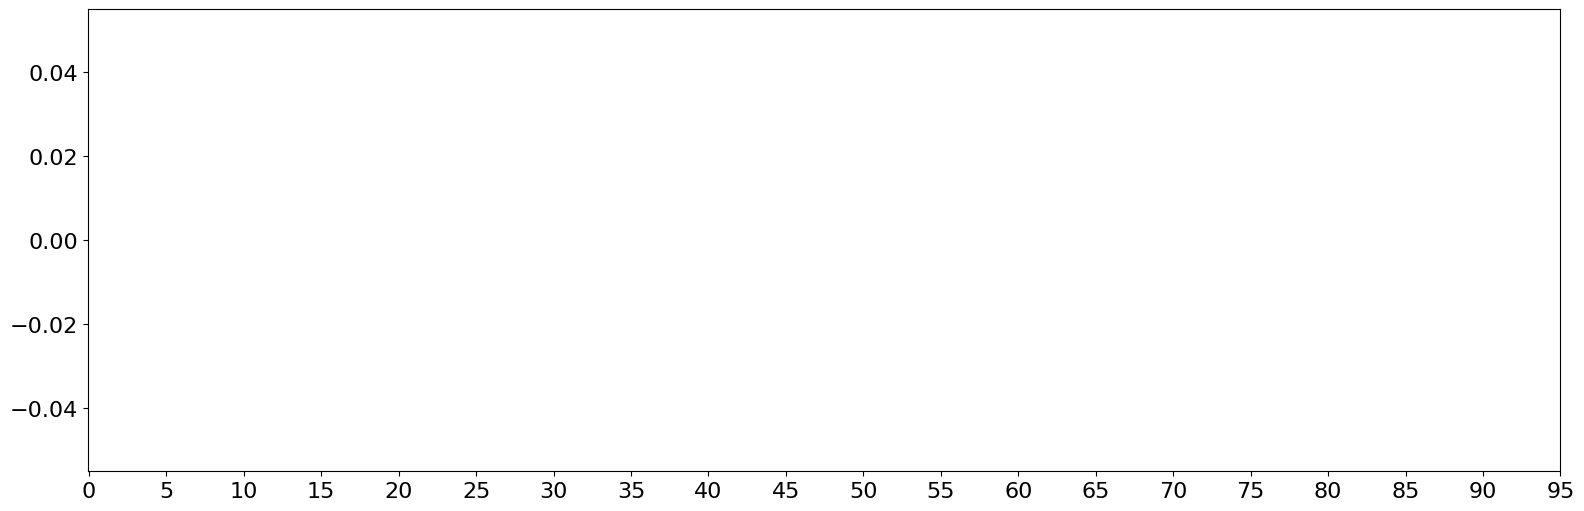

In [181]:
pass_value_barh(data)

In [182]:
data.head()

,date_crawled,price,vehicle_type,registration_year,gear_box,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,pictures_amount,postal_code,last_seen,date_difference
0,2016-03-24,480,no_info,1993,manual,0,golf,150000,0,petrol,volkswagen,no_info,2016-03-24,0,70435,2016-04-07,0
1,2016-03-24,18300,coupe,2011,manual,190,no_info,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07,0
2,2016-03-14,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no_info,2016-03-14,0,90480,2016-04-05,0
3,2016-03-17,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17,0
4,2016-03-31,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06,0



Пропуски имеются исключительно в категориальных признаках.

Пропуски заполнены.

## Анализ числовых признаков на аномалии

In [183]:
data.dtypes

date_crawled          object
price                  int64
vehicle_type          object
registration_year      int64
gear_box              object
power                  int64
model                 object
kilometer              int64
registration_month     int64
fuel_type             object
brand                 object
repaired              object
date_created          object
pictures_amount        int64
postal_code            int64
last_seen             object
date_difference        int64
dtype: object

Для анализа распределения воспользуемся графиками.

Для этого заранее подготовим переменные в которых сохраним названия признаков содержащих одинаковый тип данных.

In [184]:
categorical_columns = data.select_dtypes(include = 'object').columns
numeric_columns = data.select_dtypes(include = 'number').columns

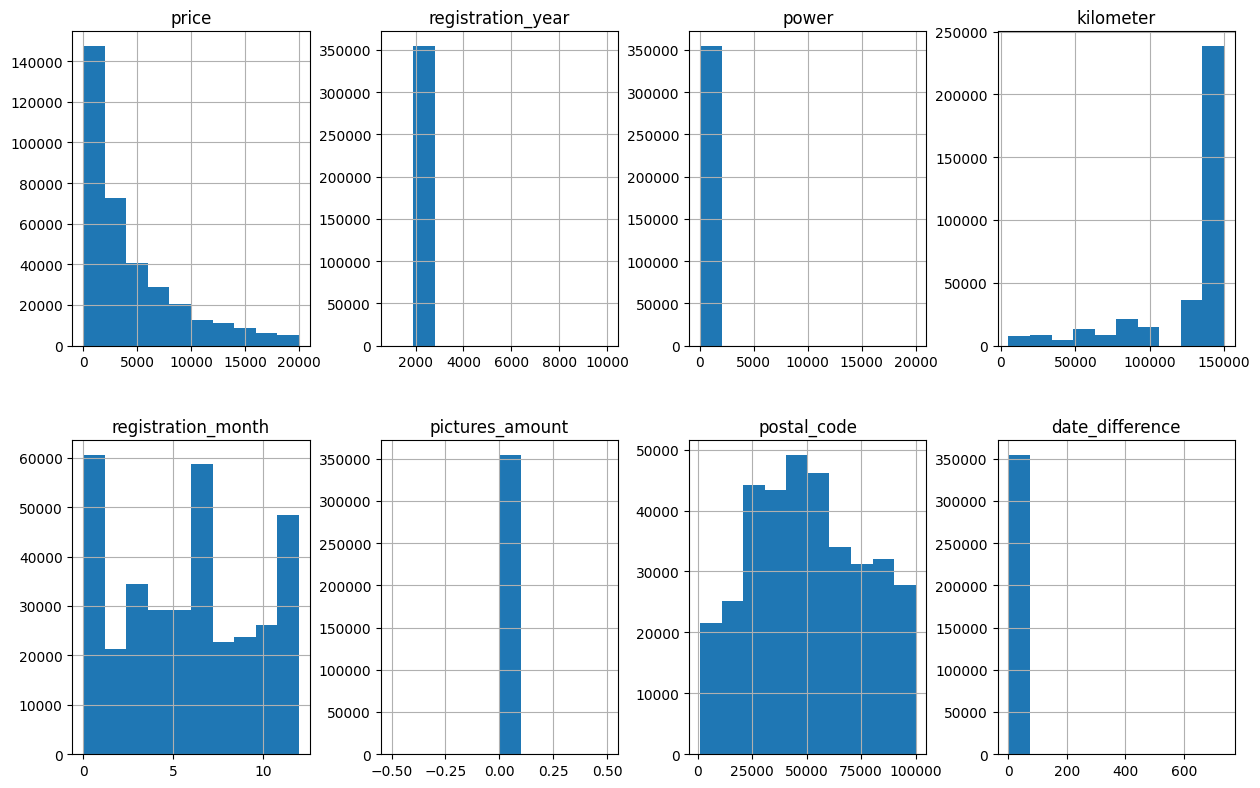

In [185]:
# Оценим визуально признаки, их распределение
data[numeric_columns].hist(layout=(4,4),figsize=(15, 20));

- price нужно изучить на наличие аномалий
- в признаке registration_year очевидно имееются аномалии
- признак power нужно проверить на систему в которой выражена мощность.
- kilometer имеются редкие значения, но аномалий не видно на этом графике
- pictures_amount возможно содержат отрицательные значения, что является аномалией
- sale_month, postal_code в обработке и анализе не нуждаются

#### registration_year

Начнем с этого признака, так как там несомненные аномалии

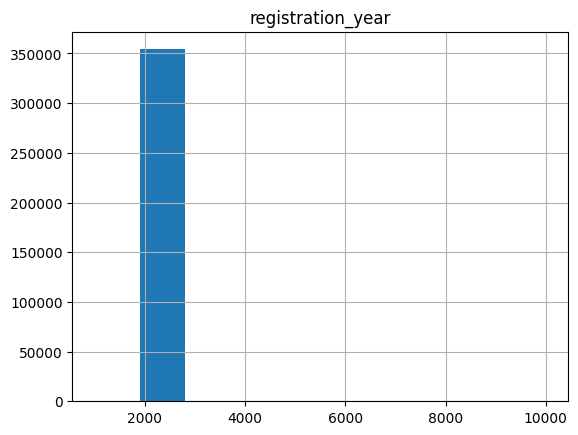

In [186]:
data[['registration_year']].hist();

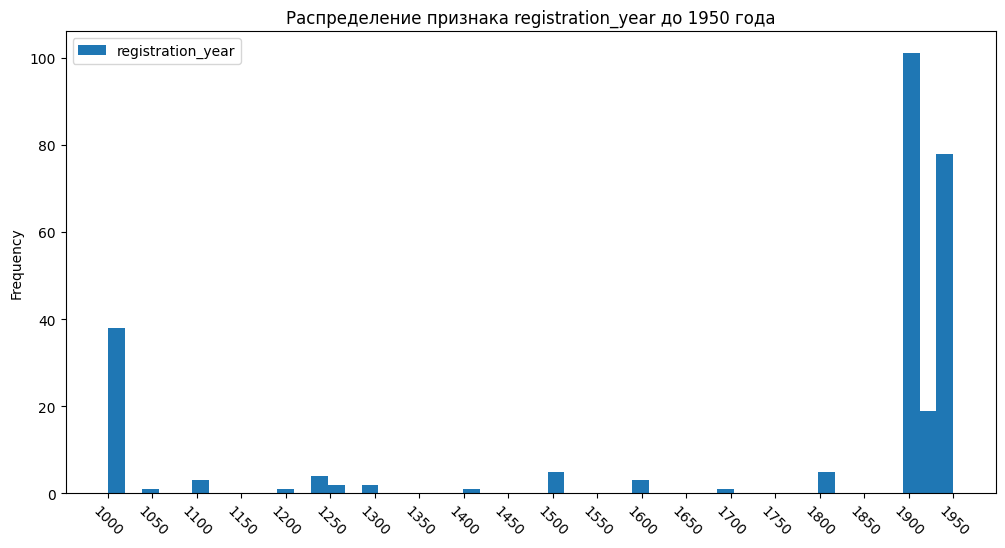

In [187]:
data[['registration_year']].plot(
    kind = 'hist',
    range = (int(data[['registration_year']].min()), 1950),
    bins = 50,
    xticks=[x for x in range(1000, 1970, 50)],
    rot = -45,
    figsize = (12,6)
);
plt.title ('Распределение признака registration_year до 1950 года');

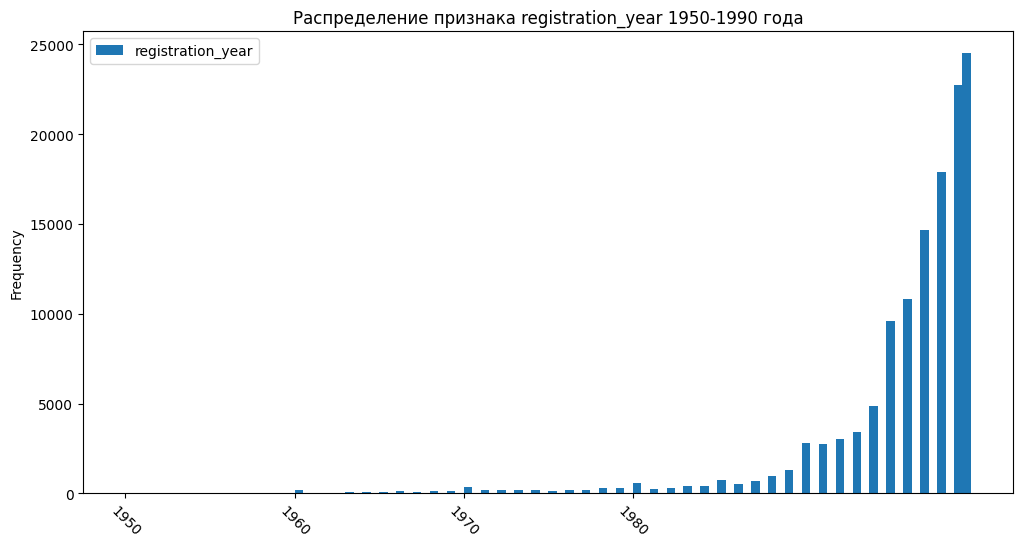

In [188]:
data[['registration_year']].plot(
    kind = 'hist',
    range = (1950, 2000),
    bins = 100,
    xticks=[x for x in range(1950, 1990, 10)],
    rot = -45,
    figsize = (12,6)
);
plt.title ('Распределение признака registration_year 1950-1990 года');

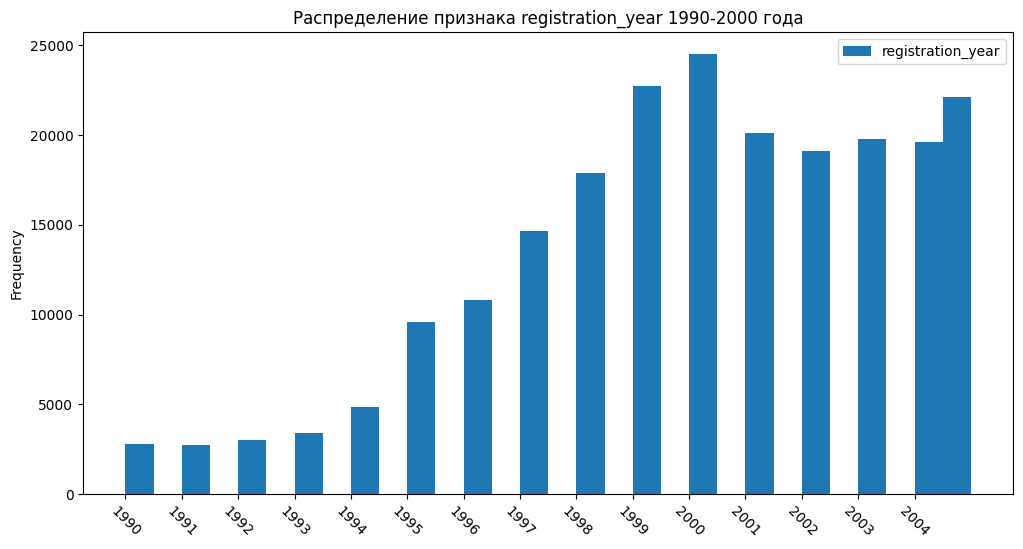

In [189]:
data[['registration_year']].plot(
    kind = 'hist',
    range = (1990, 2005),
    bins = 30,
    xticks=[x for x in range(1990, 2005, 1)],
    rot = -45,
    figsize = (12,6)
);
plt.title ('Распределение признака registration_year 1990-2000 года');

In [190]:
data['registration_year'].quantile([.03, .04, .05,.1,.50, .7, .95, .98]).to_frame().transpose()

,0.03,0.04,0.05,0.10,0.50,0.70,0.95,0.98
registration_year,1990.0,1991.0,1992.0,1995.0,2003.0,2007.0,2016.0,2017.0


Оставляем объекты зарегистрированные в период с 1990 г по 2017.

In [191]:
data = data.loc[(data['registration_year']>1990) & (data['registration_year']<=2017)]
data.shape[0]

337805

,0.03,0.04,0.05,0.10,0.50,0.70,0.95,0.98
registration_year,1994.0,1994.0,1995.0,1996.0,2003.0,2007.0,2016.0,2017.0


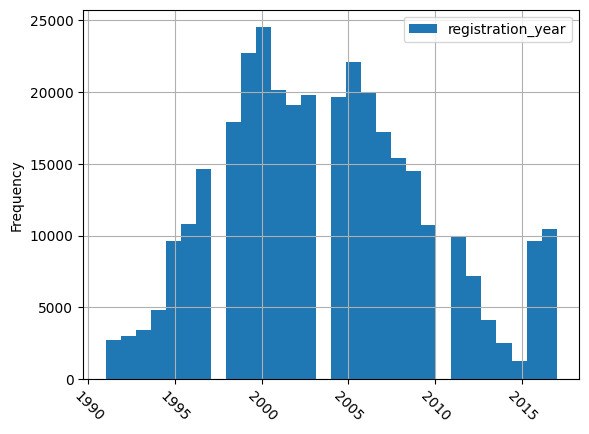

In [192]:
data[['registration_year']].plot(kind = 'hist',
                                 bins = 30,
                                 rot = -45,
                                 xticks = [x for x in range(1990, 2017, 5)],
                                 grid = True)
data['registration_year'].quantile([.03, .04, .05,.1,.50, .7, .95, .98]).to_frame().transpose()

####  price

,count,mean,std,min,25%,50%,75%,max
price,337805.0,4437.472006,4518.00206,0.0,1099.0,2750.0,6460.0,20000.0


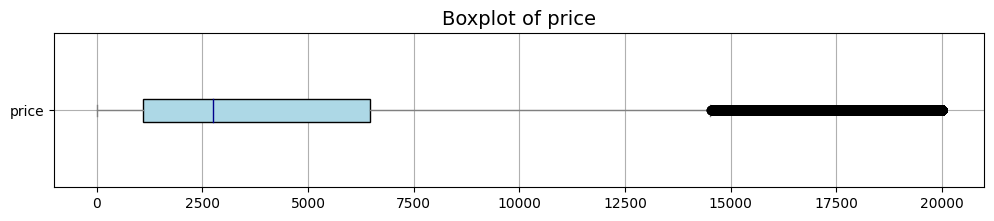

In [193]:
data.boxplot(column=['price'],
             figsize=(12, 2),
             vert=False,
             patch_artist=True,
             boxprops=dict(facecolor='lightblue'),
             whiskerprops=dict(color='gray'),
             medianprops=dict(color='darkblue'),
             capprops=dict(color='gray')).set_title('Boxplot of price',
                                                    fontsize=14);
# Посмотрим на распределение
data['price'].describe().to_frame().transpose()

Мы видим, что присутствуют объекты с нулевой стоимостью, это явные аномалии.
Для стоимости автомобиля такой разбег по стоимости вполне допустим при условии что остальные признаки не противоречат, например высокая стоимость для автомобиля с большим пробегом, возрастом и марки "дешевого" ценового сегмента. И здесь сложнее сделать вывод по выбросам, так как очевидно, что автомобили премиум сегмента и очень старые автомобили (которые продают на запчасти или подросткам) будут сильно различаться в цене.


In [194]:
data['price'].quantile([.02, .03, .04, .05,.1,.50, .7, .95, .98]).to_frame().transpose()


,0.02,0.03,0.04,0.05,0.10,0.50,0.70,0.95,0.98
price,0.0,1.0,150.0,200.0,500.0,2750.0,5400.0,14600.0,17499.0


In [195]:
data.loc[data['price']==0].shape[0]

9474

Мы получаем, что 2.67% данных это объекты с нулевой стоимостью.
Их определенно нужно удалить. Иначе наши предсказания с высокой вероятностью будут иметь большее число отрицательных значений, что невозможно и потребуется более тщательная постобработка предсказаний.

In [196]:
data = data.loc[data['price']>0]
data.head()

,date_crawled,price,vehicle_type,registration_year,gear_box,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,pictures_amount,postal_code,last_seen,date_difference
0,2016-03-24,480,no_info,1993,manual,0,golf,150000,0,petrol,volkswagen,no_info,2016-03-24,0,70435,2016-04-07,0
1,2016-03-24,18300,coupe,2011,manual,190,no_info,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07,0
2,2016-03-14,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no_info,2016-03-14,0,90480,2016-04-05,0
3,2016-03-17,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17,0
4,2016-03-31,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06,0


,0.001,0.050,0.100,0.500,0.700,0.950,0.980
price,1.0,350.0,590.0,2900.0,5500.0,14800.0,17500.0


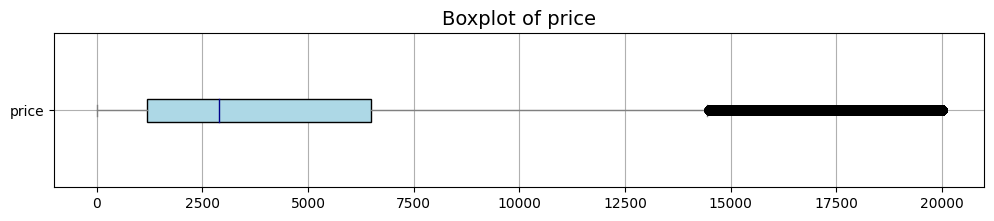

In [197]:
data.boxplot(column=['price'],
             figsize=(12, 2),
             vert=False,
             patch_artist=True,
             boxprops=dict(facecolor='lightblue'),
             whiskerprops=dict(color='gray'),
             medianprops=dict(color='darkblue'),
             capprops=dict(color='gray')).set_title('Boxplot of price',
                                                    fontsize=14);
data['price'].quantile([.001, .05,.1,.50, .7, .95, .98]).to_frame().transpose()

Избавимся от редких значений: оставим только объекты с ценой выше 200 евро, что соответствует 5 квантилю.

In [198]:
data = data.loc[data['price']>200]
data.head()

,date_crawled,price,vehicle_type,registration_year,gear_box,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,pictures_amount,postal_code,last_seen,date_difference
0,2016-03-24,480,no_info,1993,manual,0,golf,150000,0,petrol,volkswagen,no_info,2016-03-24,0,70435,2016-04-07,0
1,2016-03-24,18300,coupe,2011,manual,190,no_info,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07,0
2,2016-03-14,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no_info,2016-03-14,0,90480,2016-04-05,0
3,2016-03-17,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17,0
4,2016-03-31,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06,0


,0.001,0.050,0.100,0.500,0.700,0.950,0.980
price,230.0,499.0,650.0,2997.5,5700.0,14900.0,17500.0


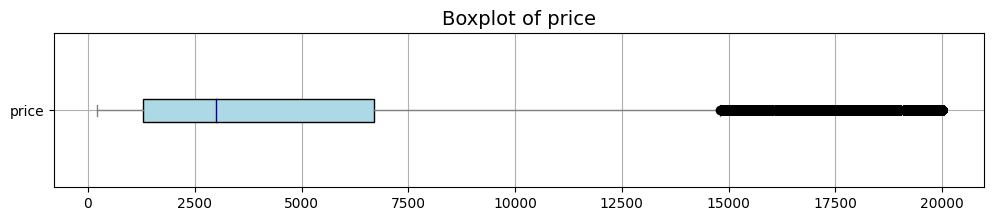

In [199]:
data.boxplot(column=['price'],
             figsize=(12, 2),
             vert=False,
             patch_artist=True,
             boxprops=dict(facecolor='lightblue'),
             whiskerprops=dict(color='gray'),
             medianprops=dict(color='darkblue'),
             capprops=dict(color='gray')).set_title('Boxplot of price',
                                                    fontsize=14);
data['price'].quantile([.001, .05,.1,.50, .7, .95, .98]).to_frame().transpose()

In [200]:
data['price'].quantile([.001, .05,.1,.50, .7, .95, .98]).to_frame().transpose()

,0.001,0.050,0.100,0.500,0.700,0.950,0.980
price,230.0,499.0,650.0,2997.5,5700.0,14900.0,17500.0


In [201]:
data[['price']].describe()

,price
count,320244.000000
mean,4677.668400
std,4519.019456
min,202.000000
25%,1299.000000
50%,2997.500000
75%,6700.000000
max,20000.000000


После удаления объектов с аномально низкой и редким значением стоимости мы видим, что:
-  средняя цена выросла с 4437 до 4670
- медианная стоимость незначительно упала с 2750 до 2700.0

Параметры выборки изменились в допустимых размерах.

Проанализируем объекты хвостовой части. Их мы рассмотрим совместно с пробегом и датой регистрацией автомобиля, так как большой пробег для высокой цены нелогичен.

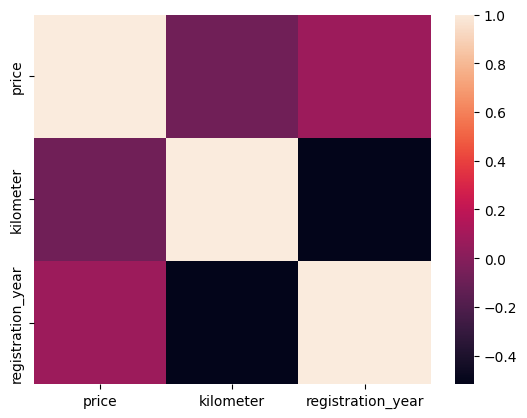

In [202]:
sns.heatmap(data.loc[data['price']>15000, ['price','kilometer','registration_year']]\
                              .sort_values(
                                          by = ['price','kilometer'],
                                          ascending=False)\
                               .corr());


Эти объекты действительно похожи на аномальные, так как не видно четкой зависимости между этими параметрами, тогда как в реальной жизни будет существовать зависимость:
- старше автомобиль- больше пробег
- больше пробег - ниже стоимость.
Если зависимость между годом регистрации и пробегом мы наблюдаем (хоть и не убедительную), то зависимость цены от этих параметров мы не наблюдаем вовсе.



In [203]:
data.loc[data['price']>15000, 'kilometer'].value_counts().to_frame().transpose()

,150000,125000,60000,70000,50000,80000,90000,100000,40000,30000,20000,10000,5000
kilometer,3924,1635,1055,1016,1006,988,928,908,901,794,697,254,167


In [204]:
data.loc[data['price']>15000, 'registration_year'].value_counts().sort_values(ascending = False).to_frame().head(15).transpose()

,2011,2012,2010,2009,2013,2008,2014,2007,2006,2015,2005,2004,2017,2003,2016
registration_year,2186,1938,1729,1434,1391,1335,990,959,588,421,291,173,153,130,107


Посмотри на признак date_crawled (дата скачивания анкеты), чтобы понять когда сервис начал продавать автомобили

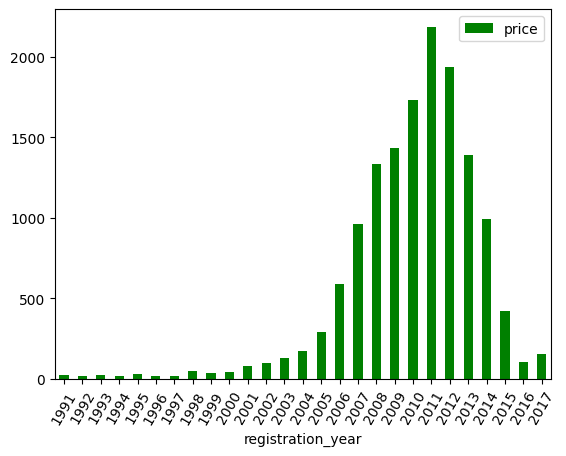

In [205]:
data.loc[data['price']>15000].groupby('registration_year')[['price']].count().plot(kind = 'bar',
                                                        rot = 60,
                                                        color = 'green');

In [206]:
pd.to_datetime(data['date_crawled']).dt.year.value_counts()


2016    320244
Name: date_crawled, dtype: int64

На этом графике мы видим, что объекты стоимостью > 15 тыс присутствуют во всех возрастных категориях, без исключений, что неправдоподобно.
Еще одна странная особенность, что наибольшее число дорогих объектов находятся в диапазоне 2007-2014 год, что странно, учитывая что все анкеты скачаны не позднее 2016 г, что говорит о том, что дата продажи не ранее 2016 г.
Значит объекты зарегистрированные в 2007 году к моменту продажи будут очень старые для такой стоимости.

Удалим объекты для которых справедливы 2 условия:
- цена выше 15 тыс
- registration_year < 2014

In [207]:
data.loc[(data['price']>=15000) & (data['registration_year']>2014)].shape[0]

714

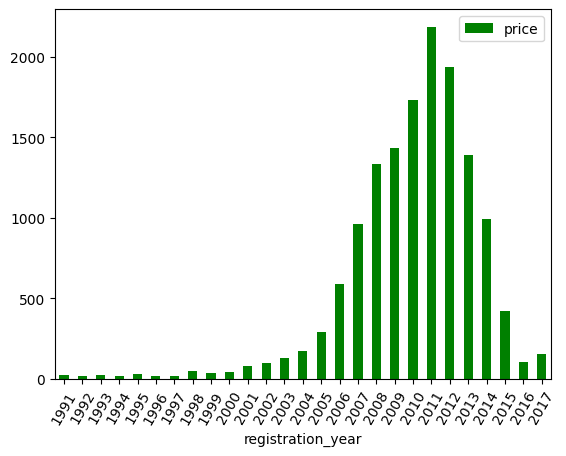

In [208]:
data.loc[data['price']>15000].groupby('registration_year')[['price']].count().plot(kind = 'bar',
                                                        rot = 60,
                                                        color = 'green');

In [209]:
index_to_drop = data[(data['price'] >= 15000) & (data['registration_year'] < 2014)].index
index_to_drop

Int64Index([     1,     14,     33,    172,    204,    236,    282,    287,
               313,    388,
            ...
            354122, 354159, 354180, 354187, 354210, 354257, 354259, 354279,
            354306, 354319],
           dtype='int64', length=13073)

In [210]:
data.drop(index = index_to_drop, inplace=True)

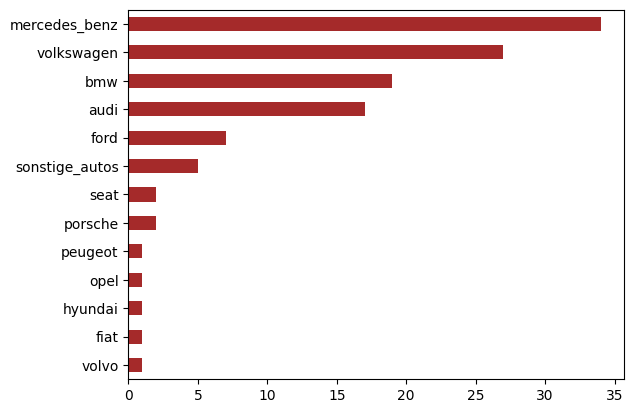

In [211]:
data.loc[(data['price']>=15000) & (data['kilometer']>100000), 'brand']\
              .value_counts(ascending = True)\
              .plot( kind = 'barh',
                    color = 'brown');

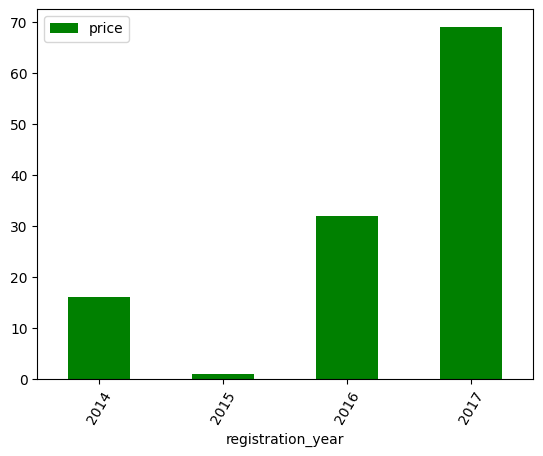

In [212]:
data.loc[(data['price']>=15000) & (data['kilometer']>100000)]\
                  .groupby('registration_year')[['price']]\
                  .count().plot(kind = 'bar',
                                rot = 60,
                                color = 'green');

<Axes: >

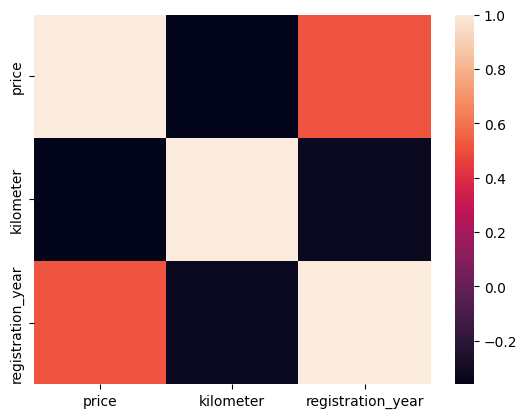

In [213]:
sns.heatmap(data[['price','kilometer','registration_year']].corr())

In [214]:
data['price'].quantile([.001, .05,.1,.50, .7, .95, .98]).to_frame().transpose()

,0.001,0.050,0.100,0.500,0.700,0.950,0.980
price,230.0,490.0,650.0,2800.0,5100.0,12400.0,14000.0


Теперь карта дешевых объектов не противоречит логике:
- высокая стоимость характерна для автомобилей премиум сегмента
- количество дорогих объектов (несмотря на высокий пробег) увеличивается по мере уменьшения возраста.

#### kilometer

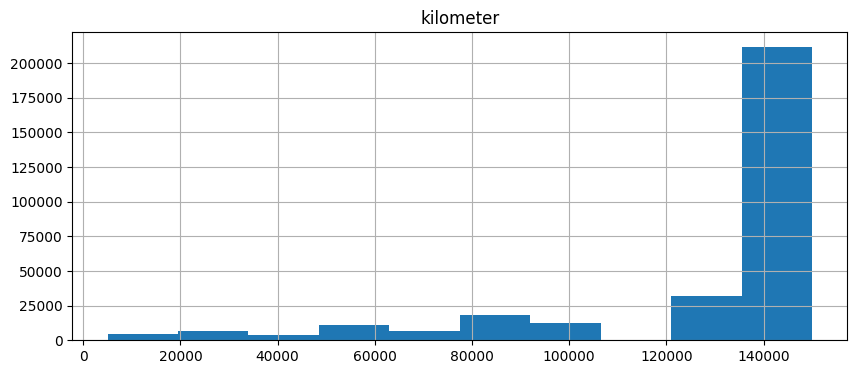

In [215]:
data[['kilometer']].hist(figsize=(10, 4));



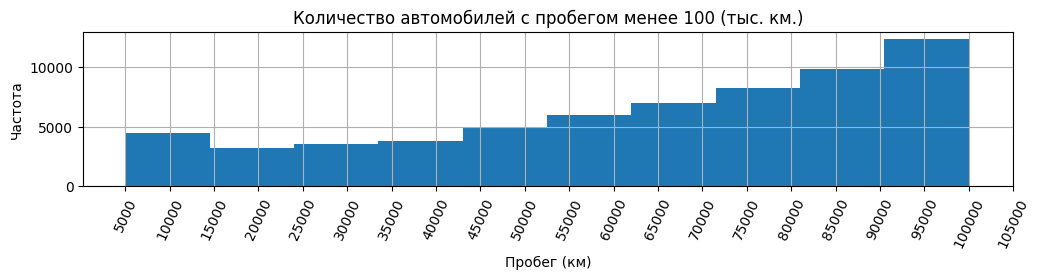

In [216]:
# гистограмма распределения количества автомобилей с пробегом менее 100 тыс
data.loc[data['kilometer']<=100000, 'kilometer'].hist(figsize=(12, 2))
plt.xticks([j for j in range(5000, 110000, 5000)],
           rotation=65)
plt.title('Количество автомобилей с пробегом менее 100 (тыс. км.)')
plt.xlabel('Пробег (км)')
plt.ylabel('Частота')
plt.show()


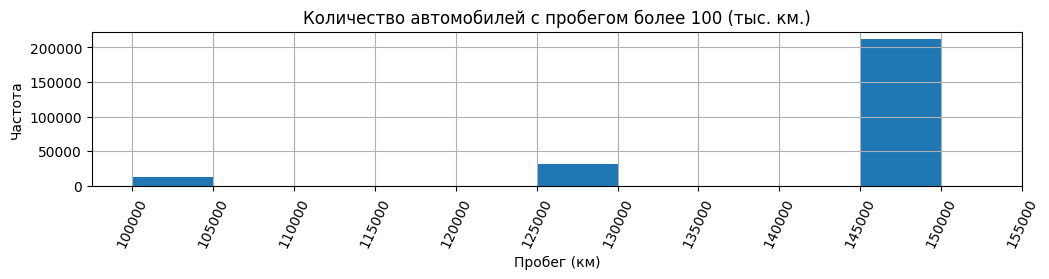

In [217]:
# гистограмма количества автомобилей с пробегом от 100 тыс
data.loc[data['kilometer']>=100000, 'kilometer'].hist(figsize=(12, 2))
plt.xticks([j for j in range(100000, 160000, 5000)],
           rotation=65)
plt.title('Количество автомобилей с пробегом более 100 (тыс. км.)')
plt.xlabel('Пробег (км)')
plt.ylabel('Частота')
plt.show()


Гистограмма распределения объектов с большим пробегом выглядит очень странно:
- данные как будто сгруппированны по каждым 20 км и гистограмма имеет прерывистый вид
- тогда как гистограмма объектов с пробегом до 100 тыс непрерывна.

Это наводит меня на мысль, что после 100 тыс появилились синтетически в базе(возможно с другого агрегатора).

Тем не менее, обработать аномалии не получится, так как они сгруппированы по категориям уже, и сейчас данные выглядят реалистичными.

####power

При анализе этого параметра будем исходить из того, что минимальная мощность это 20 л.с а максимальная 1000.

In [218]:
data.loc[(data['power']<=20) | (data['power']>1000)]


,date_crawled,price,vehicle_type,registration_year,gear_box,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,pictures_amount,postal_code,last_seen,date_difference
0,2016-03-24,480,no_info,1993,manual,0,golf,150000,0,petrol,volkswagen,no_info,2016-03-24,0,70435,2016-04-07,0
32,2016-03-15,245,sedan,1994,no_info,0,golf,150000,2,petrol,volkswagen,no,2016-03-15,0,44145,2016-03-17,0
37,2016-03-28,1500,no_info,2016,no_info,0,kangoo,150000,1,gasoline,renault,no,2016-03-28,0,46483,2016-03-30,0
54,2016-03-17,4700,wagon,2005,manual,0,signum,150000,0,no_info,opel,no,2016-03-17,0,88433,2016-04-04,0
55,2016-03-26,550,wagon,1999,manual,0,astra,150000,8,gasoline,opel,yes,2016-03-26,0,56759,2016-04-01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354336,2016-03-05,3299,no_info,2005,auto,0,outlander,150000,4,petrol,mitsubishi,no_info,2016-03-05,0,17034,2016-03-06,0
354346,2016-03-07,2600,no_info,2005,auto,0,c_klasse,150000,9,no_info,mercedes_benz,no_info,2016-03-07,0,61169,2016-03-08,0
354360,2016-04-02,3999,wagon,2005,manual,3,3er,150000,5,gasoline,bmw,no,2016-04-02,0,81825,2016-04-06,0
354363,2016-03-27,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no,2016-03-27,0,26624,2016-03-29,0


Очень большое количество аномальных значений которые удалять мы не будем из соображений сохранения данных.

Все объекты мы разделим на несколько категорий в зависимости от мощности.

- **1** группа: до 100 л.с.  Микроавтомобили и компактные автомобили, обычно это небольшие городские автомобили
-  **2** группа: от 100 до 200 л.с.   Это типичные легковые автомобили для повседневного использования.

- **3** группа: от 200 до 300 л.с. Бизнес-класс и премиум-автомобили

- **4** группа: от 300 л.с. до 400 л.с. Спортивные автомобили

- **5** группа: от 400 л.с. и выше. Это автомобили с экстремальной производительностью и инновационными технологиями.

Обратим внимание на автомобили с мощностью более 200. Если они не соответствуют по марке и стоимости премиум сегменту то заменим мощность на более низкую, так как вероятнее всего это ошибка.

Выбирать будем только по условию минимальной цены - цена для автомобилей с мощностью более 200 л.с. должна быть выше 5 тыс.

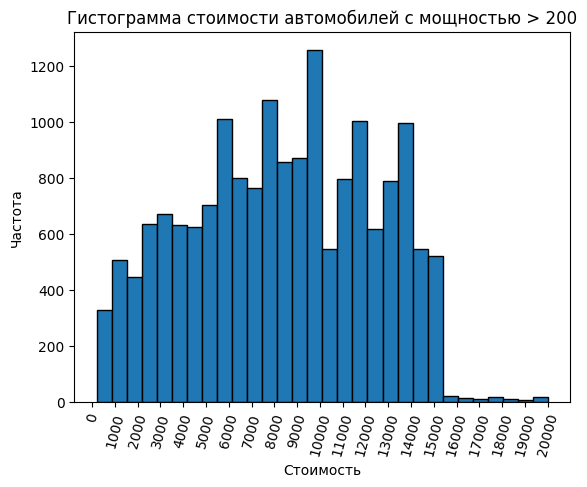

In [219]:
data_to_plot = data.loc[data['power'] > 200, 'price']
plt.hist(data_to_plot,
         bins=30,
         edgecolor='black')
plt.xlabel('Стоимость')
plt.xticks(range(0, 21000, 1000),
           rotation=75)
plt.ylabel('Частота')
plt.title('Гистограмма стоимости автомобилей с мощностью > 200')
plt.show()

In [220]:
data.loc[(data['power'] > 200) & (data['price'] < 5000)].shape[0]

4120

In [221]:
data.loc[data['power'] <= 100, 'power_category'] = 1
data.loc[
    (100 < data['power'])
    & (data['power']<= 200), 'power_category'] = 2

# для высокомощных объектов добавляем цену в условие
data.loc[
    (200 < data['power'])
    & (data['power']<= 300)
    & (data['price'] >= 5000), 'power_category'] = 3
data.loc[
    (200 < data['power'])
    & (data['power']<= 300)
    & (data['price'] < 5000),'power_category'] = 2

data.loc[
    (300 < data['power'])
    & (data['power']<= 400)
    & (data['price'] >= 5000), 'power_category'] = 4
data.loc[
    (300 < data['power'])
    & (data['power']<= 400)
    & (data['price'] < 5000), 'power_category'] = 2

data.loc[
    (400 < data['power'])
    & (data['power']<= 500)
    & (data['price'] >= 5000), 'power_category'] = 5
data.loc[
    (400 < data['power'])
    & (data['power']<= 500)
    & (data['price'] < 5000), 'power_category'] = 2

data.loc[
    (data['power'] > 500)
    & (data['price'] >= 5000),'power_category'] = 6
data.loc[
    (data['power'] > 500)
    & (data['price'] < 5000),'power_category'] = 2

Проверим не осталось ли объектов с мощностью более 200 при низкой стоимости

In [222]:
data.query('price< 5000')[['power_category']].value_counts()

power_category
1.0               113776
2.0                99369
dtype: int64

In [223]:
# удалим признак power
data = data.drop('power', axis = 1)

#### pictures_amount

In [224]:
data['pictures_amount'].unique()

array([0])

Как видим этот признак неинформативен,  так как не содержит никакой информации и одинаков для всех объектов.

In [225]:
data = data.drop( 'pictures_amount', axis=1)
data.head()

,date_crawled,price,vehicle_type,registration_year,gear_box,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,postal_code,last_seen,date_difference,power_category
0,2016-03-24,480,no_info,1993,manual,golf,150000,0,petrol,volkswagen,no_info,2016-03-24,70435,2016-04-07,0,1.0
2,2016-03-14,9800,suv,2004,auto,grand,125000,8,gasoline,jeep,no_info,2016-03-14,90480,2016-04-05,0,2.0
3,2016-03-17,1500,small,2001,manual,golf,150000,6,petrol,volkswagen,no,2016-03-17,91074,2016-03-17,0,1.0
4,2016-03-31,3600,small,2008,manual,fabia,90000,7,gasoline,skoda,no,2016-03-31,60437,2016-04-06,0,1.0
5,2016-04-04,650,sedan,1995,manual,3er,150000,10,petrol,bmw,yes,2016-04-04,33775,2016-04-06,0,2.0


### Анализ категориальных признаков

In [226]:
for column in categorical_columns:
    print (column, data[column].nunique())
    print ()

date_crawled 34

vehicle_type 9

gear_box 3

model 248

fuel_type 8

brand 40

repaired 3

date_created 108

last_seen 34



Уберем из этих признаков дату и модель автомобилей, чтобы удобно было визуализировать.

In [227]:
categorical_columns

Index(['date_crawled', 'vehicle_type', 'gear_box', 'model', 'fuel_type',
       'brand', 'repaired', 'date_created', 'last_seen'],
      dtype='object')

In [228]:
categorical_columns = ['vehicle_type', 'gear_box',  'fuel_type', 'repaired']

In [229]:
data[categorical_columns].head()

,vehicle_type,gear_box,fuel_type,repaired
0,no_info,manual,petrol,no_info
2,suv,auto,gasoline,no_info
3,small,manual,petrol,no
4,small,manual,gasoline,no
5,sedan,manual,petrol,yes


Визуализируем уникальные значения для каждого признака

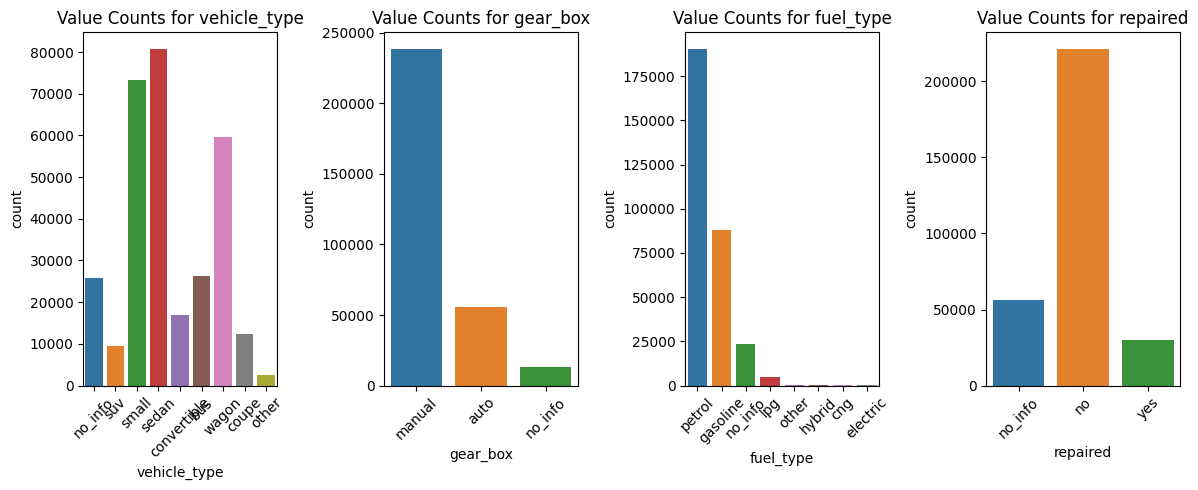

In [230]:
num_plots = len(categorical_columns)
fig, axes = plt.subplots(1, num_plots, figsize=(12, 5))

for i, col in enumerate(categorical_columns):
    ax = axes[i]
    sns.countplot(data=data, x=col, ax=ax)
    ax.set_title(f'Value Counts for {col}')

    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.tight_layout()

plt.show()

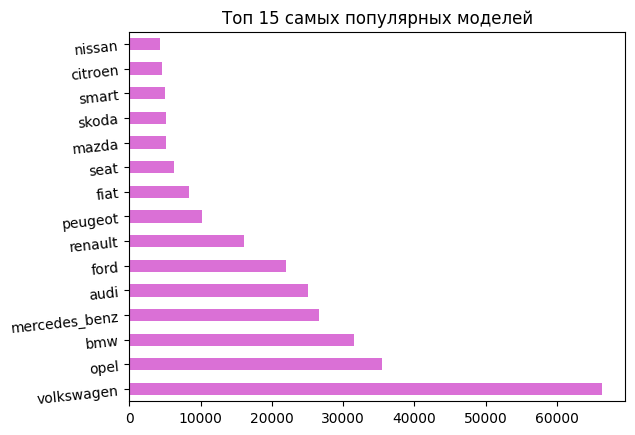

In [231]:
data['brand'].value_counts().sort_values(ascending = False).head(15)\
              .plot(kind = 'barh',
                    rot = 6,
                    color = 'orchid')
plt.title('Топ 15 самых популярных моделей')
plt.show()

In [232]:
#проверим на неявные дупликаты
data['brand'].unique()

array(['volkswagen', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford', 'mazda',
       'renault', 'mercedes_benz', 'seat', 'citroen', 'honda', 'fiat',
       'opel', 'mini', 'smart', 'hyundai', 'audi', 'nissan', 'alfa_romeo',
       'subaru', 'volvo', 'mitsubishi', 'kia', 'lancia', 'toyota',
       'chevrolet', 'dacia', 'suzuki', 'sonstige_autos', 'daihatsu',
       'chrysler', 'jaguar', 'daewoo', 'rover', 'porsche', 'saab',
       'land_rover', 'lada', 'trabant'], dtype=object)

In [233]:
data['model'].unique()

array(['golf', 'grand', 'fabia', '3er', '2_reihe', 'c_max', '3_reihe',
       'passat', 'polo', 'twingo', 'a_klasse', 'scirocco', '5er', 'arosa',
       'c4', 'civic', 'punto', 'e_klasse', 'clio', 'kadett', 'kangoo',
       'other', 'one', 'fortwo', '1er', 'b_klasse', 'signum', 'astra',
       'a8', 'jetta', 'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter',
       '156', 'no_info', 'escort', 'forester', 'xc_reihe', 'scenic', 'a4',
       'ka', 'a1', 'insignia', 'transporter', 'combo', 'focus', 'tt',
       'corsa', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'eos', 'touran',
       'getz', 'a3', 'almera', 'megane', 'lupo', 'r19', 'zafira',
       'mondeo', 'cordoba', 'colt', 'impreza', 'vectra', 'berlingo',
       'tiguan', 'i_reihe', 'espace', 'sharan', '6_reihe', 'panda', 'up',
       'seicento', 'ceed', '5_reihe', 'yeti', 'octavia', 'mii',
       'rx_reihe', 'modus', 'fox', 'matiz', 'beetle', 'c1', 'rio',
       'logan'

In [234]:
for brand in data['brand'].unique():
    print(brand,
          data.loc[data['brand']==brand, 'model'].nunique(),
          data.loc[data['brand']==brand, 'model'].unique())
    print()

volkswagen 23 ['golf' 'passat' 'polo' 'scirocco' 'other' 'jetta' 'transporter' 'no_info'
 'eos' 'touran' 'lupo' 'tiguan' 'sharan' 'up' 'fox' 'beetle' 'caddy'
 'phaeton' 'touareg' 'cc' 'bora' 'kaefer' 'amarok']

jeep 5 ['grand' 'wrangler' 'cherokee' 'other' 'no_info']

skoda 8 ['fabia' 'yeti' 'octavia' 'roomster' 'other' 'no_info' 'citigo' 'superb']

bmw 11 ['3er' '5er' '1er' '7er' 'z_reihe' 'no_info' 'other' 'x_reihe' 'm_reihe'
 '6er' 'i3']

peugeot 7 ['2_reihe' '3_reihe' 'no_info' 'other' '4_reihe' '1_reihe' '5_reihe']

ford 15 ['c_max' 'fiesta' 'escort' 'ka' 'focus' 'mondeo' 's_max' 'other' 'galaxy'
 'transit' 'no_info' 'fusion' 'kuga' 'b_max' 'mustang']

mazda 9 ['3_reihe' 'other' '6_reihe' '5_reihe' 'rx_reihe' '1_reihe' 'mx_reihe'
 'no_info' 'cx_reihe']

renault 11 ['twingo' 'clio' 'kangoo' 'scenic' 'no_info' 'megane' 'r19' 'espace'
 'modus' 'other' 'laguna']

mercedes_benz 19 ['a_klasse' 'e_klasse' 'b_klasse' 'other' 'c_klasse' 'vito' 'sprinter'
 'slk' 'viano' 'clk' 's_klasse' 'no

неявных дупликатов не обнаружила

### Признаки с датой

In [235]:
data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year',
       'gear_box', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'postal_code', 'last_seen',
       'date_difference', 'power_category'],
      dtype='object')

In [236]:
date_columns = ['date_crawled', 'date_created','registration_year', 'registration_month', 'last_seen']

In [237]:
data[date_columns].head()

,date_crawled,date_created,registration_year,registration_month,last_seen
0,2016-03-24,2016-03-24,1993,0,2016-04-07
2,2016-03-14,2016-03-14,2004,8,2016-04-05
3,2016-03-17,2016-03-17,2001,6,2016-03-17
4,2016-03-31,2016-03-31,2008,7,2016-04-06
5,2016-04-04,2016-04-04,1995,10,2016-04-06


Выше мы сравнили признаки date_crawled и date_created. Мы добавили новый синтетический признак 'date_difference', который содержит разницу с момента скачивания до момента создания анкеты. Поэтому удалим признак date_crawled.


In [238]:
data = data.drop('date_crawled', axis =1)

In [239]:
data.shape[0]

307171

In [240]:
# сравним date_created и last_seen.
period = (data['last_seen'] - data['date_created']).dt.days

In [241]:
period.describe().to_frame()

,0
count,307171.000000
mean,8.594701
std,8.624584
min,0.000000
25%,2.000000
50%,6.000000
75%,13.000000
max,759.000000


Неясно что происходит с анкетой после продажи или срок дезактивации, но можно предположить что средний срок продажи для большинства пользователей это 14 дней.


In [242]:
date_columns = ['date_created', 'registration_year', 'registration_month', 'last_seen']

In [243]:
data[date_columns].head()

,date_created,registration_year,registration_month,last_seen
0,2016-03-24,1993,0,2016-04-07
2,2016-03-14,2004,8,2016-04-05
3,2016-03-17,2001,6,2016-03-17
4,2016-03-31,2008,7,2016-04-06
5,2016-04-04,1995,10,2016-04-06


Добавим новый признак разницу между date_created и last_seen, чтобы удалить признак last_seen и оставить у признака date_created месяц и год.

In [244]:
data['lastseen_days'] = period
data['lastseen_days']

0         14
2         22
3          0
4          6
5          2
          ..
354363     2
354365    23
354366     6
354367    19
354368     4
Name: lastseen_days, Length: 307171, dtype: int64

In [245]:
data = data.drop('last_seen', axis = 1)

In [246]:
data['created_year'] = pd.to_datetime(data['date_created']).dt.year

In [247]:
data['created_month'] = pd.to_datetime(data['date_created']).dt.month

In [248]:
data = data.drop('date_created', axis = 1)

In [249]:
data.head()

,price,vehicle_type,registration_year,gear_box,model,kilometer,registration_month,fuel_type,brand,repaired,postal_code,date_difference,power_category,lastseen_days,created_year,created_month
0,480,no_info,1993,manual,golf,150000,0,petrol,volkswagen,no_info,70435,0,1.0,14,2016,3
2,9800,suv,2004,auto,grand,125000,8,gasoline,jeep,no_info,90480,0,2.0,22,2016,3
3,1500,small,2001,manual,golf,150000,6,petrol,volkswagen,no,91074,0,1.0,0,2016,3
4,3600,small,2008,manual,fabia,90000,7,gasoline,skoda,no,60437,0,1.0,6,2016,3
5,650,sedan,1995,manual,3er,150000,10,petrol,bmw,yes,33775,0,2.0,2,2016,4


Добавим новый признак - возраст автомобиля

In [250]:
data['avto_age'] = data['created_year'] - data['registration_year']
data['avto_age'].head()

0    23
2    12
3    15
4     8
5    21
Name: avto_age, dtype: int64

In [251]:
data.head()

,price,vehicle_type,registration_year,gear_box,model,kilometer,registration_month,fuel_type,brand,repaired,postal_code,date_difference,power_category,lastseen_days,created_year,created_month,avto_age
0,480,no_info,1993,manual,golf,150000,0,petrol,volkswagen,no_info,70435,0,1.0,14,2016,3,23
2,9800,suv,2004,auto,grand,125000,8,gasoline,jeep,no_info,90480,0,2.0,22,2016,3,12
3,1500,small,2001,manual,golf,150000,6,petrol,volkswagen,no,91074,0,1.0,0,2016,3,15
4,3600,small,2008,manual,fabia,90000,7,gasoline,skoda,no,60437,0,1.0,6,2016,3,8
5,650,sedan,1995,manual,3er,150000,10,petrol,bmw,yes,33775,0,2.0,2,2016,4,21


Дубликатов не наблюдается.

In [252]:
#data.to_csv('data_preproceced', sep=',', index=False, encoding='utf-8')

# Машинное обучение

**Обоснование выбора модели**

Согласно заданию нам необходимо обязательно использовать простые модели (не бустинг), поэтому я решила использовать две модели библиотеки Sclearn:
- LinearRegression
- RandomForestRegressor.

Я выбрала эти модели по следующим соображениям:
- **LinearRegression** работают быстрее, а учитывая что для нашей работы время обучения и предсказания являются важными метриками, то я решила начать с самой быстрой модели, которая может дать необходимую метрику `RMSE <2500`.

- RandomForestRegressor отличается высокой точностью предсказаний на дефолтных параметрах и имеется возможность подобрать гиперпараметры, в отличии от линейной регрессии.

Далее я буду использовать алгоритмы градиентного бустинга:

- CatBoostRegressor
- LightGBM.

Для всех моделей я буду делать подбор гиперпараметров методом **RandomisedGridsearchCV**.

Выбор этого метода подбора так же продиктован ограниченностью вычислительных ресурсов, т.к. **GridsearchCV** перебирает большее число параметров, а значит увеличивается время на работу данного метода.
**Optuna** крайне ресурсозатратна, и при таком низком пороге метрики ее использование нецелесообразно.




### Делим выборки

In [253]:
#Разделим выборки
train, validation = train_test_split(data,
                                     random_state=21,
                                     test_size = 0.4)
validation, test = train_test_split(validation,
                                    random_state=21,
                                    test_size = 0.5)
print('train', train.shape[0])
print()
print('validation', validation.shape[0])
print()
print('test', test.shape[0])

train 184302

validation 61434

test 61435


In [254]:
#выделим обучающие признаки и целевой признак
features = data.drop('price', axis = 1)
target = data['price']
data.columns
X = list(features.columns)
y = ['price']

In [255]:
categorical = list(features.select_dtypes(include = ['object', 'bool']).columns)
numeric = list(features.select_dtypes(include = ['number']).columns)
print('categorical', categorical)
print()
print('numeric', numeric)

categorical ['vehicle_type', 'gear_box', 'model', 'fuel_type', 'brand', 'repaired']

numeric ['registration_year', 'kilometer', 'registration_month', 'postal_code', 'date_difference', 'power_category', 'lastseen_days', 'created_year', 'created_month', 'avto_age']


#### Масштабирование и Перекодирование признаков

Наши данные содержат категориальные и числовые признаки, которые нужно обрабатывать прежде чем можно передать их в выбранные нами модели машинного обучения.

Поэтому мы будем использовать **pipeline** для предобработки и для обучения.
pipeline предобработки включает в себя следующие этапы:

**Трансформер для числовых признаков**:
- масштабирование StandartScaler
- анализ важности признаков PCA(Principal Component Analysis)

**Трансформер для категориальных признаков**:
- кодирование с помощью OneHotEncoder для линейной модели
- кодирование с помощью OrdinalEncoder для 'деревянных' моделей.

P.s. изначально я использовала один энкодер для всех моделей, но из-за того, что импеются признаки, содержадщие много уникальных категорий (model, brand) после использования OneHotEncoder деревянные модели обучались более 4 часов.

**ColumnTransformer** для объединения результатов трансформаций в одну матрицу признаков


In [ ]:
numeric_transformer = Pipeline(
    steps =[
        ('scl', StandardScaler()),
         ('pca', PCA(n_components = 0.95))
    ])

In [ ]:
categorical_transformer = Pipeline(
    steps = [('enc', OneHotEncoder(handle_unknown='ignore'))])

In [ ]:
preprocessor = ColumnTransformer( transformers=[
        ("num", numeric_transformer, numeric),
        ("cat", categorical_transformer, categorical),
    ])

#### Linear_Regression

In [ ]:
lr_pipe=Pipeline(steps = [('preprocess', preprocessor),
 ('clf',LinearRegression())])

In [ ]:
start = time.time()
lr_pipe.fit(train, train[y])
end = time.time()
lr_fit_time = end - start
print(lr_fit_time, 'сек')

3.4517626762390137 сек


In [ ]:
start = time.time()
predict_lr = lr_pipe.predict(validation)
end = time.time()
lr_pred_time = end - start
print(lr_pred_time, 'сек' )

0.15883302688598633 сек


In [ ]:
rmse_lr = mean_squared_error(validation[y], predict_lr, squared=False)
mape_lr = mean_absolute_percentage_error(validation[y], predict_lr)

print(f'RMSE LinearRegression: {rmse_lr:.3f}')
print()
print(f'MAPE LinearRegression: {mape_lr:.3f}%')

RMSE LinearRegression: 2045.281

MAPE LinearRegression: 0.855%


#### Random_Forest_Regressor

In [ ]:
categorical_transformer = Pipeline(
    steps = [('enc', OrdinalEncoder())])

In [ ]:
tree_preprocessor = ColumnTransformer(transformers=[
        ("num", numeric_transformer, numeric),
        ("cat", categorical_transformer, categorical),
    ])

In [ ]:
rand_forest_pipe=Pipeline(steps = [('preprocess', tree_preprocessor),
 ('rand_forest', RandomForestRegressor(random_state=42))])

In [ ]:
start = time.time()

rand_forest_pipe.fit(train, train[y])

end = time.time()
rand_forest_fit_time = end - start
print(rand_forest_fit_time, 'сек')

/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


235.37975358963013 сек


In [ ]:
params = rand_forest_pipe.named_steps['rand_forest'].get_params()
params

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [ ]:
start = time.time()

predict_rand_forest = rand_forest_pipe.predict(validation)

end = time.time()
rand_forest_predict_time = end - start
print(rand_forest_predict_time, 'сек')

2.3994195461273193 сек


In [284]:
rmse_rand_forest = mean_squared_error(validation[y],
                                     predict_rand_forest,
                                     squared=False)
mape_rand_forest = mean_absolute_percentage_error(validation[y], predict_rand_forest)

print(f'RMSE RandomForestRegressor: {rmse_rand_forest:.3f}')
print()
print(f'MAPE RandomForestRegressor: {mape_rand_forest:.3f}%')

RMSE RandomForestRegressor: 1499.410

MAPE RandomForestRegressor: 0.448%


In [285]:
index = ['linear_regression', 'random_forest_regressor']
columns = ['RMSE', 'MAPE', 'fit_time (сек)', 'predict_time (сек)']
data = [[mean_squared_error(validation[y], predict_lr, squared=False),
        mean_absolute_percentage_error(validation[y], predict_lr),
         lr_fit_time,
         lr_pred_time],
        [mean_squared_error(validation[y], predict_rand_forest, squared=False),
        mean_absolute_percentage_error(validation[y], predict_rand_forest),
         rand_forest_fit_time,
         rand_forest_predict_time]]

In [286]:
result = pd.DataFrame(data = data,
             index = index,
             columns = columns)
result

,RMSE,MAPE,fit_time (сек),predict_time (сек)
linear_regression,2045.280660,0.854789,3.451763,0.158833
random_forest_regressor,1499.409935,0.447684,235.379754,2.399420


Таким образом, требуемый показатель метрики MSE < 2500 был достигнут на обеих моделях при дефолтных гиперпараметрах.



#### Randomised_SearchCV


Добавим перебор параметров для модели случайного леса

In [ ]:
param_grid = (
    {'bootstrap': [True, False],
     'n_estimators': [100, 200],
     'max_depth': [10, 20, 30],
     'min_samples_leaf': [4,  8, 15, 20]})

In [ ]:
best_model = None
estimator= RandomForestRegressor(random_state=42)

In [334]:
rf_random_search = RandomizedSearchCV(estimator = estimator,
                                      param_distributions = param_grid,
                                      n_iter = 50,
                                      cv = 3,
                                      verbose=1,
                                      random_state=42,
                                      n_jobs = -1)
rf_random_search

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30],
                                        'min_samples_leaf': [4, 8, 15, 20],
                                        'n_estimators': [100, 200]},
                   random_state=42, verbose=1)

In [ ]:
random_gscv_pipe = Pipeline(steps = [('prepp', tree_preprocessor),
                               ('randomised_grid_search', rf_random_search)])

In [335]:
start = time.time()

random_gscv_pipe.fit(train, train[y])

end = time.time()
random_gscv_fit_time = end - start
print('randomised search fit time:', random_gscv_fit_time, 'сек')

Fitting 3 folds for each of 10 candidates, totalling 30 fits


KeyboardInterrupt: ignored

In [133]:
best_model = random_gscv_pipe.named_steps['randomised_grid_search'].best_estimator_
best_model

RandomForestRegressor(max_depth=30, min_samples_leaf=8, n_estimators=200,
                      random_state=42)

In [272]:
best_model_params = best_model.get_params()
best_model_params

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 30,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 8,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [295]:
start = time.time()

rand_search_predict = random_gscv_pipe.predict(validation)

end = time.time()
rand_search_predict_time = end - start
print('randomised search predict time:', rand_search_predict_time, 'сек')

randomised search predict time: 2.7771430015563965 сек


In [303]:
rmse_best_parameters = mean_squared_error(validation[y],
                                          rand_search_predict,
                                          squared=False)
mape_best_parameters = mean_absolute_percentage_error(validation[y], rand_search_predict)
print(f'RMSE RandomForestRegressor (best_parameters): {rmse_best_parameters  :.3f}')
print(f'MAPE RandomForestRegressor (best_parameters): {mape_best_parameters :.3f}%')

RMSE RandomForestRegressor (best_parameters): 1531.247
MAPE RandomForestRegressor (best_parameters): 0.451%


In [317]:
result

,RMSE,MAPE,fit_time (сек),predict_time (сек)
linear_regression,2045.280660,0.854789,3.451763,0.158833
random_forest_regressor,1499.409935,0.447684,235.379754,2.399420


In [331]:
rmse_best_parameters

1531.247363686789

In [332]:
row = pd.Series({
'RMSE':rmse_best_parameters,
'MAPE':mape_best_parameters,
'fit_time (сек)': random_gscv_fit_time,
'predict_time (сек)': rand_search_predict_time},
          name='random_forest_regressor(best_params)')


In [376]:
result = result.append(row)
result

<ipython-input-376-5ddefe81512e>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(row)


Мы видим, что поиск оптимальных гиперпараметров используя RandomisedGridSearchCV не улучшил результат модели, это может быть с тем, что необходимо увеличть границы поисков гиперпараметров, но мы ограничены временем выполнения вычислени, поэтому мы не будем продолжать поиск гиперпарметров учитывая, что лучшее значение метрики RMSE	у нас 1500, при минимально необходимом 2500.

## Модели градиентного бустинга

### СatBoost

Для СatBoost мы будем использовать некодированные данные.

Так же для удобства будем использовать объект Pool библиотеки Catboost.

In [336]:
categorical

['vehicle_type', 'gear_box', 'model', 'fuel_type', 'brand', 'repaired']

In [337]:
cat_features = categorical

In [338]:
train_pool = Pool(data=train[X],
                  label=train[y],
                  cat_features=cat_features)
print(train_pool.shape[0])

184302


In [339]:
validation_pool = Pool(data=validation[X],
                       label=validation[y],
                  cat_features=cat_features)
print(validation_pool.shape[0])

61434


In [340]:
test_pool = Pool(data=test[X],
                  label=test[y],
                  cat_features=cat_features)
print(test_pool.shape[0])

61435


In [366]:
params = {
    'cat_features': cat_features,
    'eval_metric': 'MAPE',
    'loss_function': 'RMSE',
    'random_seed': 42,
    'verbose': 100
    }

In [368]:
#инициализируем модель
model = CatBoostRegressor(**params)

In [370]:
start = time.time()

model.fit(train_pool)

end = time.time()
catboost_fit_time = end - start
print ('catboost_fit_time:', catboost_fit_time)

Learning rate set to 0.093354
0:	learn: 1.8315708	total: 178ms	remaining: 2m 57s
100:	learn: 0.4528161	total: 18.9s	remaining: 2m 48s
200:	learn: 0.4291669	total: 51.9s	remaining: 3m 26s
300:	learn: 0.4182052	total: 1m 10s	remaining: 2m 42s
400:	learn: 0.4120399	total: 1m 24s	remaining: 2m 6s
500:	learn: 0.4074153	total: 1m 38s	remaining: 1m 37s
600:	learn: 0.4039398	total: 1m 54s	remaining: 1m 15s
700:	learn: 0.4012891	total: 2m 10s	remaining: 55.8s
800:	learn: 0.3981964	total: 2m 25s	remaining: 36.2s
900:	learn: 0.3960518	total: 2m 41s	remaining: 17.8s
999:	learn: 0.3943841	total: 2m 54s	remaining: 0us
catboost_fit_time: 175.81109237670898


In [373]:
start = time.time()

catboost_prediction = model.predict(validation_pool)

end = time.time()
catboost_predict_time = end - start
print ('catboost_predict_time:', catboost_predict_time)

catboost_predict_time: 0.27930212020874023


In [374]:
rmse_catboost = mean_squared_error(validation[y],
                                          catboost_prediction,
                                          squared=False)
mape_catboost = mean_absolute_percentage_error(validation[y],
                                               catboost_prediction)

print(f'RMSE catboostRegressor: {rmse_catboost  :.3f}')
print(f'MAPE catboostRegressor): {mape_catboost :.3f}%')

RMSE catboostRegressor: 1393.551
MAPE catboostRegressor): 0.400%


In [379]:
row = pd.Series({
'RMSE':rmse_catboost,
'MAPE':mape_catboost,
'fit_time (сек)': catboost_fit_time,
'predict_time (сек)': catboost_predict_time},
          name='CatBoost')
result = result.append(row)

<ipython-input-379-7a8a6c085e65>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(row)


,RMSE,MAPE,fit_time (сек),predict_time (сек)
linear_regression,2045.280660,0.854789,3.451763,0.158833
random_forest_regressor,1499.409935,0.447684,235.379754,2.399420
random_forest_regressor(best_params),1531.247364,0.451097,4925.457344,2.777143
CatBoost,1393.551433,0.400288,175.811092,0.279302


In [380]:
result

,RMSE,MAPE,fit_time (сек),predict_time (сек)
linear_regression,2045.280660,0.854789,3.451763,0.158833
random_forest_regressor,1499.409935,0.447684,235.379754,2.399420
random_forest_regressor(best_params),1531.247364,0.451097,4925.457344,2.777143
CatBoost,1393.551433,0.400288,175.811092,0.279302


### Подбор гиперпараметров CatBoost через RandomGridSearch

In [381]:
# параметры для перебора
param_grid = {
    'learning_rate': [0.001, 0.010, 0.10, 0.15],
    'depth': [6, 15, 20],
    'l2_leaf_reg': [1, 3, 5, 7, 9]
    }

In [ ]:
model = CatBoostRegressor()

In [ ]:
now = datetime.datetime.now()

gs_result = model.randomized_search(param_grid,
                                    train_pool,
                                    plot=True)

end = datetime.datetime.now()
catboost_rs_time = end-now
print('catboost randomized search time', catboost_rs_time)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 5577.9860227	test: 5587.0760743	best: 5587.0760743 (0)	total: 233ms	remaining: 3m 53s
1:	learn: 5573.3318085	test: 5582.4390109	best: 5582.4390109 (1)	total: 371ms	remaining: 3m 5s
2:	learn: 5568.7233759	test: 5577.8426634	best: 5577.8426634 (2)	total: 561ms	remaining: 3m 6s
3:	learn: 5564.1149811	test: 5573.2441227	best: 5573.2441227 (3)	total: 710ms	remaining: 2m 56s
4:	learn: 5559.4429225	test: 5568.5837899	best: 5568.5837899 (4)	total: 876ms	remaining: 2m 54s
5:	learn: 5554.7800741	test: 5563.9015163	best: 5563.9015163 (5)	total: 1.04s	remaining: 2m 52s
6:	learn: 5550.1782467	test: 5559.3045534	best: 5559.3045534 (6)	total: 1.16s	remaining: 2m 45s
7:	learn: 5545.5700747	test: 5554.7108899	best: 5554.7108899 (7)	total: 1.32s	remaining: 2m 44s
8:	learn: 5541.0201366	test: 5550.1525417	best: 5550.1525417 (8)	total: 1.44s	remaining: 2m 38s
9:	learn: 5536.3675766	test: 5545.5067979	best: 5545.5067979 (9)	total: 1.58s	remaining: 2m 36s
10:	learn: 5531.7310867	test: 5540.8755424

In [ ]:
gs_result.best_score_

In [ ]:
best_params = gs_result['params']
best_params

In [ ]:
# оцениваем
catboost_best_params = model.predict(validation_pool)

In [ ]:
rmse = mean_squared_error(validation[y], y_pred, squared=False)

#  MAPE
mape = mean_absolute_percentage_error(validation[y], y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.3f}%")

In [ ]:
fstrs = model.get_feature_importance(prettified=True)

fig, ax = plt.subplots()
fstrs.plot(x='Feature Id', y='Importances', kind='bar', ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel("Значение")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
best_model = CatBoostRegressor(**best_params,
                               random_seed= 42,
                              verbose = 100,
                              iterations = 1600)

In [ ]:
%%time
# обучаем модель
best_model.fit(test_pool)
print (best_model.best_score_)

In [ ]:
pred_test = CatBoostRegressor().predict(test[X])
pred_test

In [ ]:
#pred_test.loc[prediction['sellingprice']<250, 'sellingprice']=250
#pred_test.loc[prediction['sellingprice']<250].shape[0]

### Lightgbm

In [ ]:
preprocessor

In [ ]:
data =

In [ ]:
train_dataset = lgb.Dataset(data = ,
                            label = train[y])

In [ ]:
lgb_pred = lgb_model.predict(validation,
                             num_iteration = lgb_model.best_iteration
                             )